# Reading and evaluating PTB correlation data


In [1]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from empir19nrm02.tools.help import plotCorrelation
from empir19nrm02.tools import get_data_step
from empir19nrm02.MC import DistributionParam, MCVar, MCSimulation, NameUnit, MCVectorVar

import luxpy as lx
from luxpy import _CIE_ILLUMINANTS, _CMF
import pandas as pd
import seaborn as sns

out_dir = 'MCSim_XYZYxyTest'

import os
print( 'CWD:', os.getcwd())

CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


In [2]:
def seaborn_plot_result4(loc_result, relative=True, diffxy=True):
    disp_array_count, step = get_data_step(loc_result.shape[1])
    disp_array = np.zeros((4, disp_array_count - 1))
    print( loc_result[:,0])
    for i in range(disp_array_count - 1):
        if relative:
            disp_array[0, i] = loc_result[0, i * step + 1] / loc_result[0, 0]
        else:
            disp_array[0, i] = loc_result[0, i * step + 1]
        if diffxy:
            disp_array[1, i] = loc_result[1, i * step + 1] - loc_result[1, 0]
            disp_array[2, i] = loc_result[2, i * step + 1] - loc_result[2, 0]
        else:
            if relative:
                disp_array[1, i] = loc_result[1, i * step + 1] / loc_result[1, 0]
                disp_array[2, i] = loc_result[2, i * step + 1] / loc_result[2, 0]
            else:
                disp_array[1, i] = loc_result[1, i * step + 1]
                disp_array[2, i] = loc_result[2, i * step + 1]
        if diffxy:
            disp_array[3, i] = loc_result[3, i * step + 1] - loc_result[3, 0]
        else:
            disp_array[3, i] = loc_result[3, i * step + 1]

    sns.set_theme(style="ticks")
    if relative:
        if diffxy:
            df = pd.DataFrame(data=disp_array.T, columns=['$Y_{\mathrm{rel}}$', '$\Delta x$', '$\Delta y$', '$\Delta CCT$'])
        else:
            df = pd.DataFrame(data=disp_array.T, columns=['$X_{\mathrm{rel}}$', '$Y_{\mathrm{rel}}$', '$Z_{\mathrm{rel}}$', 'CCT'])
    else:
        if diffxy:
            df = pd.DataFrame(data=disp_array.T, columns=['$Y$', '$\Delta x$', '$\Delta y$', '$\Delta CCT$'])
        else:
            df = pd.DataFrame(data=disp_array.T, columns=['$X$', '$Y$', '$Z$', 'CCT'])
    grid = sns.pairplot(df, corner=True)
    if relative and diffxy:
        plotTitle = 'Observation Yxy, CCT'
    if relative and not diffxy:
        plotTitle = 'Observation XYZ, CCT'

    grid.fig.suptitle(plotTitle.format())

In [3]:
NumberTrials = 100000
wl = lx.getwlr([380,780,1])
# define some output data (as MCVar to make an analysis after the run)
mcT = MCVar(name=NameUnit('T', 'K'), distribution=DistributionParam(mean=3072., stddev=1.))
mcWl_c = MCVar(name=NameUnit('$\lambda$', 'nm'), distribution=DistributionParam(mean=0, stddev=1))

mcYxy = MCVectorVar(name=NameUnit('Yxy', ''), elements=3)
mcXYZ = MCVectorVar(name=NameUnit('XYZ', ''), elements=3)
mcCCT = MCVar(name=NameUnit('CCT', 'K'))
mcSD = MCVectorVar(name=NameUnit('SD', 'A.U.'), elements=wl.shape[0])
# define some basic data needed inside the MCS

# standard illuminant A
spectrumA = _CIE_ILLUMINANTS['A'].copy()
spectrumAInt = lx.cie_interp(spectrumA, wl_new=wl, kind='S')

# helpwise the delta lambda values for the integration
dl = lx.getwld(wl) # wavelength differences (unequal wavelength spacings are taken into account)
dl = dl*np.ones_like(wl) # ensure array like for matrix multiplication

# simple model calculating the photometric integral from the photometers
def model_L0( T, wl_c):
    #L = FEL @ (photometerI * dl)
    bb = lx.blackbody(T, wl, relative=False)
    XYZ = lx.spd_to_xyz(np.vstack((wl+wl_c, bb[1])), relative=False)
    CCT = lx.xyz_to_cct(XYZ)
    Yxy = lx.xyz_to_Yxy(XYZ)
    return [Yxy[0], XYZ[0], CCT, bb[1]]

input = [mcT, mcWl_c]
output = [mcYxy, mcXYZ, mcCCT, mcSD]

# prepare and run the MCS
sim = MCSimulation(trials=NumberTrials)
# set the input and output data
sim.set_input_var(input)
sim.set_output_var(output)
# generate/load the random numbers
sim.generate()
# calculate the model
sim.calculate_model(model_L0)

# tell the results
for i in range(len(input)+1):
    print( i)
    for var in sim.output_var[i]:
        if isinstance(var, MCVectorVar):
            if var.elements < 5:
                var.print_stat()
        else:
            var.print_stat()

Generate:
0
Name: var NameUnit(name='Yxy', unit='') Values: [array([3.6831e+16, 4.3190e-01, 4.0229e-01]), array([9.8818e+13, 6.8629e-05, 2.5293e-05])] [2.6830e-03 1.5890e-04 6.2873e-05] Interval: [array([3.6638e+16, 4.3177e-01, 4.0224e-01]), array([3.7024e+16, 4.3204e-01, 4.0234e-01])]
Set: Corr: None Cov: None
Data: Corr: None Cov: None
Name: var NameUnit(name='XYZ', unit='') Values: [array([3.9542e+16, 3.6831e+16, 1.5180e+16]), array([1.0229e+14, 9.8818e+13, 5.0281e+13])] [2.5870e-03 2.6830e-03 3.3123e-03] Interval: [array([3.9342e+16, 3.6638e+16, 1.5081e+16]), array([3.9741e+16, 3.7024e+16, 1.5278e+16])]
Set: Corr: None Cov: None
Data: Corr: None Cov: None
Name: var NameUnit(name='CCT', unit='K') Values: [3072.0058973669734, 0.9982529191628045] 0.0003249514983087794 Interval: [3070.0472475247398, 3073.9479005620024]
1
Name: var NameUnit(name='Yxy', unit='') Values: [array([3.6832e+16, 4.3190e-01, 4.0229e-01]), array([2.1396e+14, 5.6166e-04, 2.5562e-04])] [5.8090e-03 1.3004e-03 6.354

Variation of T
[3.9542e+16 3.6831e+16 1.5180e+16 3.0720e+03]


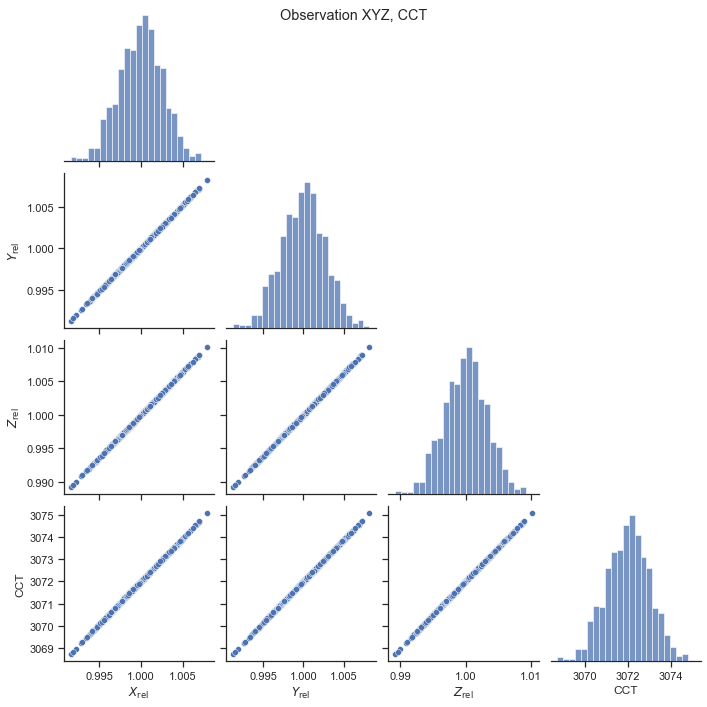

Corr_Matrix: XYZ: [[1.0000e+00 1.0000e+00 1.0000e+00]
 [1.0000e+00 1.0000e+00 1.0000e+00]
 [1.0000e+00 1.0000e+00 1.0000e+00]]
[3.6831e+16 4.3190e-01 4.0229e-01 3.0720e+03]


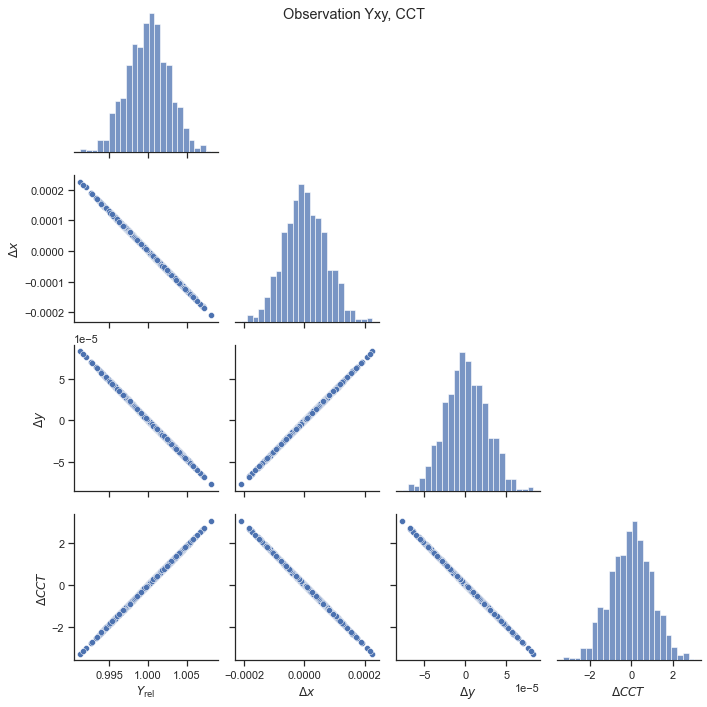

Corr_Matrix: Yxy: [[1.0000e+00 -1.0000e+00 -1.0000e+00]
 [-1.0000e+00 1.0000e+00 1.0000e+00]
 [-1.0000e+00 1.0000e+00 1.0000e+00]]
Test_T


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


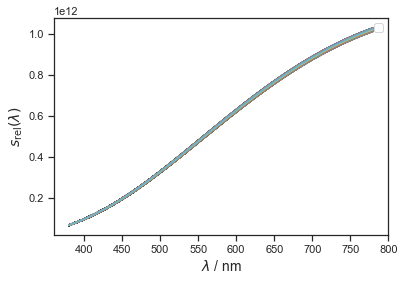

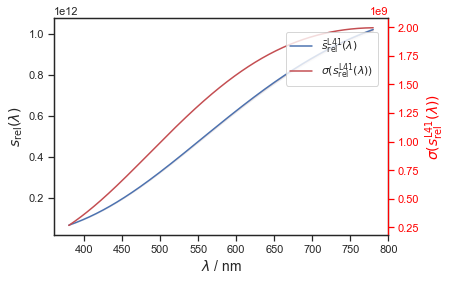

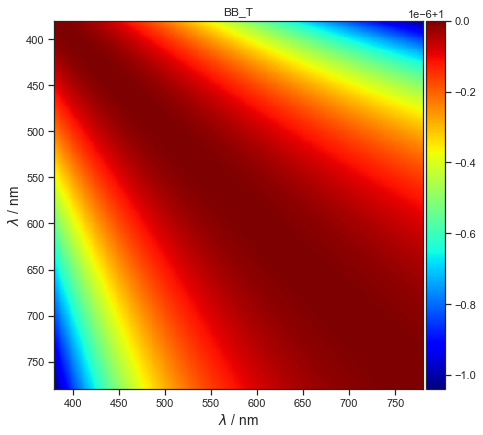

Variation of wl_c
[3.9542e+16 3.6831e+16 1.5180e+16 3.0720e+03]


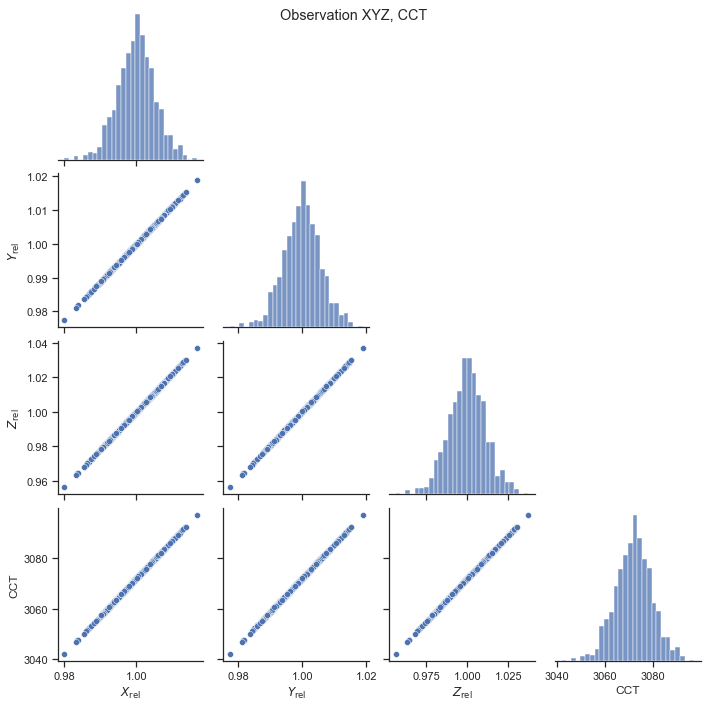

Corr_Matrix: XYZ: [[1.0000e+00 1.0000e+00 9.9999e-01]
 [1.0000e+00 1.0000e+00 9.9999e-01]
 [9.9999e-01 9.9999e-01 1.0000e+00]]
[3.6831e+16 4.3190e-01 4.0229e-01 3.0720e+03]


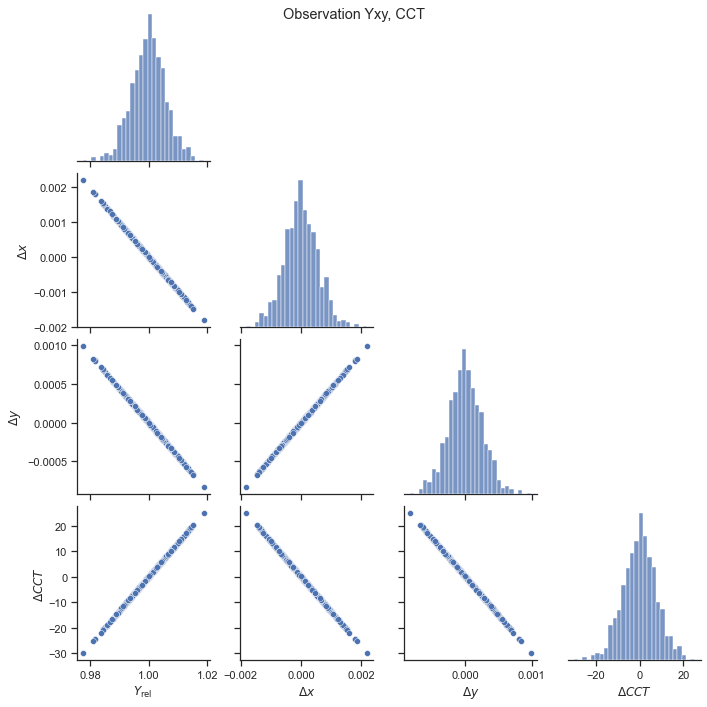

Corr_Matrix: Yxy: [[1.0000e+00 -9.9999e-01 -1.0000e+00]
 [-9.9999e-01 1.0000e+00 9.9999e-01]
 [-1.0000e+00 9.9999e-01 1.0000e+00]]
Test_wl


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


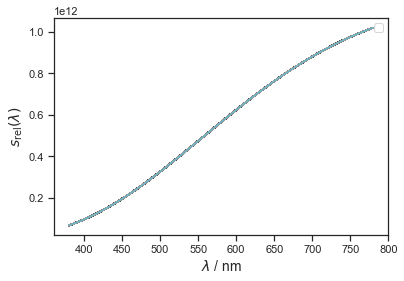

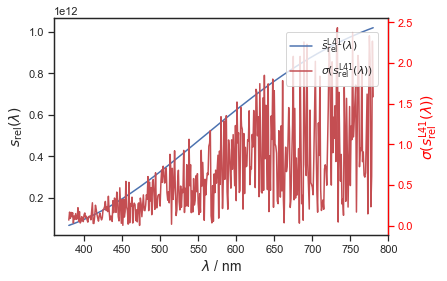

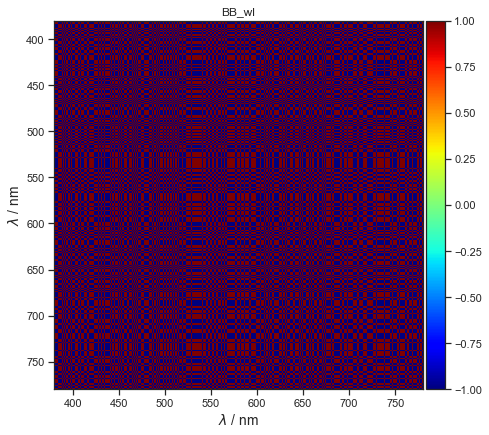

In [5]:
for item in range(2):
    # item == 0: Variation of T
    # item == 1: variation of wl-scale (full correlation)
    if item == 0:
        print( 'Variation of T')
    else:
        print( 'Variation of wl_c')
    var = sim.output_var[item]
    # XYZ and CCT
    seaborn_plot_result4(np.vstack((var[1].val.T, var[2].val.T)), relative=True, diffxy=False)
    save_fig(out_dir, 'Observation_XYZCCT')
    var[1].calc_cov_matrix_from_data()
    print( 'Corr_Matrix: XYZ:', var[1].runData.corr_matrix)

    # Yxy and CCT
    seaborn_plot_result4(np.vstack((var[0].val.T, var[2].val.T)), relative=True, diffxy=True)
    save_fig(out_dir, 'Observation_YxyCCT')
    var[0].calc_cov_matrix_from_data()
    print( 'Corr_Matrix: Yxy:', var[0].runData.corr_matrix)

    # display the collection of SD of the BB
    mcSpectrum = var[3]
    if item == 0:
        _,_ = display_responsivity( 'Test_T', np.vstack((wl, mcSpectrum.val)), cieobs='1931_2', s_target_index=0,
                              out_dir = None, plots=['plot1', 'plot2'], S_C='LED_L41', spectrum_color=False)
    else:
        _,_ = display_responsivity( 'Test_wl', np.vstack((wl, mcSpectrum.val)), cieobs='1931_2', s_target_index=0,
                              out_dir = None, plots=['plot1', 'plot2'], S_C='LED_L41', spectrum_color=False)
    # Show the correlation matrix for the cases
    mcSpectrum.calc_cov_matrix_from_data()
    if item == 0:
        plotCorrelation(mcSpectrum.runData.corr_matrix, wl, 'BB_T')
        save_fig(out_dir, 'BB_corr_T_1K')
    else:
        plotCorrelation(mcSpectrum.runData.corr_matrix, wl, 'BB_wl')
        save_fig(out_dir, 'BB_corr_wlc_1nm')